# SMART LIVE CAMERA NOTEBOOK

## Necessary modules

In [2]:
# Import Modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
import tarfile
import seaborn
import random
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import display, Image
from scipy import ndimage
from scipy.io import loadmat
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Generic functions

### Data Preprocessing Functions

In [1]:
last_percent_reported = None
num_classes = 10

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

def maybe_extract(filename, force=False):
  """Extract a file (tar). If force=True, override the current files and folders"""
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

### Eval Functions

In [3]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## 1. STEP ONE: MNIST DATA

### Downloading data

In [7]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
mnist_test_dataset = mnist.test.images
mnist_test_labels = mnist.test.labels
mnist_valid_dataset = mnist.validation.images
mnist_valid_labels = mnist.validation.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Simple Logistic Regression (Boilerplate)

In [18]:
# Defining Params
image_size = 28 # 28px 
num_labels = 10 # 0-9

# Defining the Graph
graph = tf.Graph()

with graph.as_default():
  # Input init and constant init. According to the theory 
  tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size * image_size)) 
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels)) 
  tf_valid_dataset = tf.constant(mnist_valid_dataset) 
  tf_test_dataset = tf.constant(mnist_test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels])) # mean0,low std dev, random values
  biases = tf.Variable(tf.zeros([num_labels])) # zeros
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases # logistic regression
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) # loss function based on softmax-cross entropy
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss) # GD Optimizer
  
  # Predictions for the training, validation, and test data. (Probabilities)
  train_prediction = tf.nn.softmax(logits) 
  valid_prediction = tf.nn.softmax(tf.matmul(mnist_valid_dataset, weights) + biases) 
  test_prediction = tf.nn.softmax(tf.matmul(mnist_test_dataset, weights) + biases)
  
  
# Defining hyper-parameters
batch_size = 128
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  for step in range(num_steps):
    batch_data, batch_labels = mnist.train.next_batch(batch_size)
    # Dict preparation and run training
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict) 
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(batch_data, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), mnist_valid_labels))
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), mnist_test_labels))

Minibatch loss at step 0: 11.956044
Minibatch accuracy: 0.0%
Validation accuracy: 12.2%
Minibatch loss at step 500: 0.679620
Minibatch accuracy: 0.0%
Validation accuracy: 87.1%
Minibatch loss at step 1000: 0.233264
Minibatch accuracy: 0.0%
Validation accuracy: 88.6%
Minibatch loss at step 1500: 0.482689
Minibatch accuracy: 0.0%
Validation accuracy: 89.9%
Minibatch loss at step 2000: 0.421654
Minibatch accuracy: 0.0%
Validation accuracy: 90.3%
Minibatch loss at step 2500: 0.238978
Minibatch accuracy: 0.0%
Validation accuracy: 90.7%
Minibatch loss at step 3000: 0.410421
Minibatch accuracy: 0.0%
Validation accuracy: 90.4%
Test accuracy: 90.0%


### 1-Layer Hidden NN

In [20]:
# Defining Params
image_size = 28 # 28px 
num_labels = 10 # 0-9
hidden_nodes = 1024 # H=1024

# Defining the Graph
graph = tf.Graph()

with graph.as_default():

  tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size * image_size)) 
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels)) 
  tf_valid_dataset = tf.constant(mnist_valid_dataset) 
  tf_test_dataset = tf.constant(mnist_test_dataset)
  
  # Variables.
  w1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes])) 
  b1 = tf.Variable(tf.zeros([hidden_nodes])) 
  w2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels])) 
  b2 = tf.Variable(tf.zeros([num_labels])) 
  
  def twoNN(X):
      return tf.matmul(tf.nn.relu(tf.matmul(X, w1) + b1), w2) + b2
  
  # Training computation.
  logits = twoNN(tf_train_dataset) 
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) 
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss) 
  
  # Predictions 
  train_prediction = tf.nn.softmax(logits) 
  valid_prediction = tf.nn.softmax(twoNN(mnist_valid_dataset))
  test_prediction = tf.nn.softmax(twoNN(mnist_test_dataset))
  
  
# Defining hyper-parameters
batch_size = 128
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  for step in range(num_steps):
    batch_data, batch_labels = mnist.train.next_batch(batch_size)
    # Dict preparation and run training
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict) 
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(batch_data, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), mnist_valid_labels))
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), mnist_test_labels))

Minibatch loss at step 0: 285.738281
Minibatch accuracy: 0.0%
Validation accuracy: 37.6%
Minibatch loss at step 500: 1.170302
Minibatch accuracy: 0.0%
Validation accuracy: 93.4%
Minibatch loss at step 1000: 0.260246
Minibatch accuracy: 0.0%
Validation accuracy: 94.5%
Minibatch loss at step 1500: 0.162996
Minibatch accuracy: 0.0%
Validation accuracy: 95.1%
Minibatch loss at step 2000: 0.000864
Minibatch accuracy: 0.0%
Validation accuracy: 95.1%
Minibatch loss at step 2500: 0.001277
Minibatch accuracy: 0.0%
Validation accuracy: 95.3%
Minibatch loss at step 3000: 0.004491
Minibatch accuracy: 0.0%
Validation accuracy: 95.3%
Test accuracy: 95.1%


### Training sequences

In [4]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=False)
mnist_train_dataset = mnist.train.images
mnist_train_labels = mnist.train.labels
mnist_test_dataset = mnist.test.images
mnist_test_labels = mnist.test.labels
mnist_valid_dataset = mnist.validation.images
mnist_valid_labels = mnist.validation.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
print('Training set', mnist_train_dataset.shape, mnist_train_labels.shape)
print('Validation set', mnist_valid_dataset.shape, mnist_valid_labels.shape)
print('Test set', mnist_test_dataset.shape, mnist_test_labels.shape)

Training set (55000, 784) (55000,)
Validation set (5000, 784) (5000,)
Test set (10000, 784) (10000,)


In [ ]:
# X (image input) --> H (sequence)
# N = max elements in a sequence
# L = sequence length
# 1 <= L <= N
# N = 5 --> 1 <= L <= 5

N = 5

image_size = 32
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = labels.astype(np.int32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


In [ ]:
# Defining Params
image_height = 32 # 32px 
num_labels = N+1 
num_classes = 11 # 0-9 + blank
learning_rate = 0.01 

SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
WORK_DIRECTORY = 'data'
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # Size of the validation set.
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64
NUM_EPOCHS = 10
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.

# Defining the Graph
graph = tf.Graph()

with graph.as_default():

  tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size * image_size)) 
  tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels)) 
  tf_valid_dataset = tf.constant(mnist_valid_dataset) 
  tf_test_dataset = tf.constant(mnist_test_dataset)
  
  # Variables.
  w_L = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels])) 
  b_L = tf.Variable(tf.zeros([num_labels])) 
  
  w_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels])) 
  b_1 = tf.Variable(tf.zeros([num_labels])) 
  
  w_2 = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels])) 
  b_2 = tf.Variable(tf.zeros([num_labels])) 
  
  w_3 = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels])) 
  b_3 = tf.Variable(tf.zeros([num_labels])) 
  
  w_4 = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels])) 
  b_4 = tf.Variable(tf.zeros([num_labels])) 
  
  w_5 = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels])) 
  b_5 = tf.Variable(tf.zeros([num_labels])) 
      
  def LR(X,w,b):
      return tf.matmul(X,w) + b
    
  def model(X):
    z_L = LR(X,w_L,b_L)
    z_1 = LR(X,w_1,b_1)
    z_2 = LR(X,w_2,b_2)
    z_3 = LR(X,w_3,b_3)
    z_4 = LR(X,w_4,b_4)
    z_5 = LR(X,w_5,b_5)
    return [z_L, z_1, z_2, z_3, z_4, z_5]
  
  # Training computation.
  z = model(tf.train.dataset)

  # Loss  
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(z, tf_train_labels))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) 
  
  # Predictions 
  train_prediction = tf.nn.softmax(z) 
  valid_prediction = tf.nn.softmax(model(mnist_valid_dataset))
  test_prediction = tf.nn.softmax(model(mnist_test_dataset))
  
  
# Defining hyper-parameters
batch_size = 128
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  for step in range(num_steps):
    batch_data, batch_labels = mnist.train.next_batch(batch_size)
    # Dict preparation and run training
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict) 
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(batch_data, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), mnist_valid_labels))
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), mnist_test_labels))  

### Downloading and verifying data

In [5]:
URL = 'http://ufldl.stanford.edu/housenumbers/'
TRAIN_FILENAME= 'train_32x32.mat'
TEST_FILENAME = 'test_32x32.mat'
EXTRA_FILENAME = 'extra_32x32.mat'
last_percent_reported = None

train_filename = maybe_download(TRAIN_FILENAME, 182040794)
test_filename = maybe_download(TEST_FILENAME, 64275384)
# extra_filename = maybe_download(EXTRA_FILENAME, 100) #estimated size

Found and verified train_32x32.mat
Found and verified test_32x32.mat


## Extracting data

In [32]:
# Using scipy.io.loadmat 
print('Extracting...')
train_matfile = loadmat('train_32x32.mat')
test_matfile = loadmat('test_32x32.mat')
# extra_matfile = loadmat('extra_32x32.mat')
print('Completed!')

Extracting...
Completed!


In [60]:
print('Keys: %s.' % train_matfile.keys()) # checking current keys

# Training Dataset
train_X = train_matfile['X'] 
train_y = train_matfile['y']

# Test Dataset
test_X = test_matfile['X']
test_y = test_matfile['y']

# Extra Dataset
# extra_X = extra_matfile['X']
# extra_y = extra_matfile['y']
print('Datasets ready!')

Keys: ['y', 'X', '__version__', '__header__', '__globals__'].
Datasets ready!


## Visualizing data

Image


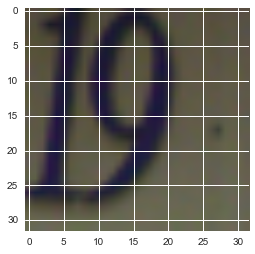

Label
[9]




In [71]:
# Set how many images want to visualize
pl_samp = 1

for _ in range(pl_samp):
  rd = random.randint(0, len(train_X))

  sample_X = train_X[:,:,:,rd]
  sample_y = train_y[rd]

  print('Image')
  plt.imshow(sample_X)
  plt.show()
  print('Label')
  print(sample_y)
  print('\n')

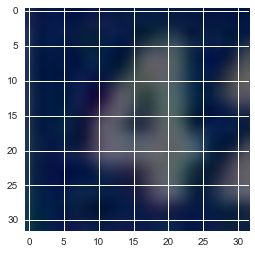

In [76]:
plt.imshow(train_X[:,:,:,26])
